# Countermeasures model v1

Changes:
* Fixed convolution by creating a tested library version
* Cleared up import code, removed obsolete mask, added text cells
* Improve plotting & writeouts
* Renamed from "basic" to v1 (this is hardly a simple model)

## Import & initialization

In [1]:
### Initial imports

import datetime
import io
import logging
from pathlib import Path

import dateutil
import datetime
import numpy as np
import pandas as pd
import pymc3 as pm
import theano
import theano.tensor as T
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from epimodel import RegionDataset, read_csv
from epimodel.pymc3_models.utils import geom_convolution

## Loading data and parameter settings

[2020-04-07 15:52:44,741] INFO(epimodel.regions): Name index has 6 potential conflicts: ['american samoa', 'georgia', 'guam', 'northern mariana islands', 'puerto rico', 'united states minor outlying islands']



CMS countermeasures-features.csv columns:
Index(['Symptomatic isolation - targeted', 'Symptomatic isolation - blanket',
       'Asymptomatic isolation - targeted', 'Asymptomatic isolation - blanket',
       'Domestic travel restriction', 'Nonessential business suspension',
       'International travel restriction', 'Testing', 'Contact tracing',
       'Mask wearing', 'Hand washing', 'Gatherings banned',
       'Healthcare specialisation', 'Public education and incentives',
       'Assisting people to stay home', 'Public cleaning',
       'Miscellaneous hygiene measures', 'Public interaction and hygiene',
       'School closure', 'Activity cancellation', 'Resumption',
       'Diagnostic criteria loosened', 'Diagnostic criteria tightened',
       'Testing criteria'],
      dtype='object')

CMS countermeasures-model-0to1.csv columns:
Index(['Gatherings limited to', 'Business suspended',
       'Schools and universities closed', 'General curfew',
       'Healthcare specialisation', 'Minor

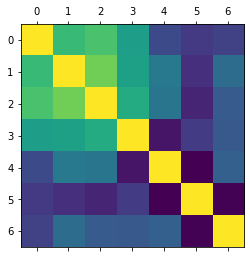

In [31]:
DATA_DIR = Path("../data")

### Import epimodel and load relevant files

from epimodel import RegionDataset, read_csv

rds = RegionDataset.load(DATA_DIR / 'regions.csv')
csse = read_csv(DATA_DIR / 'johns-hopkins.csv')

CMSS = ['countermeasures-features.csv', 'countermeasures-model-0to1.csv', 'countermeasures-selected-binary.csv']
cm_sets = {n: read_csv(DATA_DIR / n) for n in CMSS}
for n, v in cm_sets.items():
    print(f"\nCMS {n} columns:\n{v.columns!r}")
    
### Parameters and data loading

# Days
Ds = pd.date_range(start='2020-02-10', end='2020-04-05', tz='utc')
nDs = len(Ds)

# Countermeasures
CMS = cm_sets['countermeasures-model-0to1.csv']

# CMS-01 columns
CMs = ['Gatherings limited to', 'Business suspended', 'Schools and universities closed', 'General curfew',
       'Healthcare specialisation', 'Phone line',
       'Asymptomatic contact isolation'] #  'Mask wearing', 'Minor distancing and hygiene measures',]
# Selected CMS-b columns
#CMs = ["Contact isolation", "Some businesses suspended", "Many businesses suspended",
#       "Schools and universities closed", "Social distancing advised", "Gatherings limited to 10 or less",
#       "General curfew", "General strict isolation"]
nCMs = len(CMs)

# Countries (or just any regions)
#Cs0 = ["BG", "UA", "PT", "IS", "RO", "HU", "IT", "HR", "BE", "NL", "DK", "DE", "AT", "CZ", "GE", "FR", "ES", "GB", "PL", "GR", "CH", "BE", "FI", "HU", "NO", "RO", "SE", "SI", "SK"]
Cs0 = ["PT", "IS", "HU", "HR", "BE", "NL", "DK", "DE", "AT", "CZ", "GE", "FR", "ES", "GB", "PL", "GR", "CH", "BE", "FI", "NO", "SE", "SI", "SK"]
Cs = []
# Filtering just countries with JH data, countermeasures data and at least 100 cases
for cc in set(Cs0):
    c = rds[cc]
    if c.Level == "country":
        if c.Code in csse.index and c.Code in CMS.index:
            if csse.loc[(c.Code, Ds[-1]), "Active"] > 100:
                Cs.append(c.Code)
nCs = len(Cs)
print(f"\n{nCs} countries selected: {Cs!r}\n")

# Probability of being in Confirmed cases X days after transmission, from 0
# Generated from Poisson dist., must sum to 1.0
DelayProb = np.array([0.00, 0.01, 0.02, 0.06, 0.10, 0.13, 0.15, 0.15, 0.13, 0.10, 0.07, 0.05, 0.03])
print(f"Delayprob sum={DelayProb.sum()}, E[DP]={np.sum(DelayProb*np.arange(len(DelayProb)))}")

# Active countermeasures per day and region
print("\nCountermeasures                            min   .. mean  .. max")
sd = CMS.loc[Cs, CMs]
if 'Mask wearing' in CMs:
    sd['Mask wearing'] *= 0.01
for i, cm in enumerate(CMs):
    print(f"{i:2} {cm:42} {sd[cm].min().min():.3f} .. {sd[cm].mean().mean():.3f} .. {sd[cm].max().max():.3f}")
ActiveCMs = np.stack([sd.loc[c].loc[Ds].T for c in Cs])
assert ActiveCMs.shape == (nCs, nCMs, nDs)
# [country, CM, day] Which CMs are active, and to what extent
ActiveCMs = ActiveCMs.astype(theano.config.floatX)

plt.matshow(sd.corr())
plt.show()

# Confirmed cases, masking values smaller than 10
Confirmed = csse["Confirmed"].loc[(tuple(Cs), Ds)].unstack(1).values
assert Confirmed.shape == (nCs, nDs)
Confirmed[Confirmed < 10.0] = np.nan
# [country, day]
Confirmed = np.ma.masked_invalid(Confirmed.astype(theano.config.floatX))

# Active cases, masking values smaller than 10
Active = csse["Active"].loc[(tuple(Cs), Ds)].unstack(1).values
assert Active.shape == (nCs, nDs)
Active[Active < 10.0] = np.nan
# [country, day]
Active = np.ma.masked_invalid(Active.astype(theano.config.floatX))

# Masking early observations (they depend on unknown pre-existing CMs)
CMDelayCut = 10

def statstr(d):
    return f"{d.mean():.3g} ({np.quantile(d, 0.05):.3g} .. {np.quantile(d, 0.95):.3g})"

## Model definition

In [32]:
with pm.Model() as model:
    # [] Baseline growth rate (wide prior OK, mean estimates ~10% daily growth)
    BaseGrowthRate = pm.Lognormal("BaseGrowthRate", np.log(1.2), 2.0)
    
    # [country] Initial size of epidemic (the day before the start, only those detected; wide prior OK)
    InitialSize = pm.Lognormal("InitialSize", 0.0, 10, shape=(nCs,))
    
    # [country] Country growth rate
    # TODO: Estimate growth rate variance
    CountryGrowthRate = pm.Lognormal("CountryGrowthRate", pm.math.log(BaseGrowthRate), 0.3, shape=(nCs,))
    
    # [CM] How much countermeasures reduce growth rate
    # TODO: Possibly use another distribution
    CMReduction = pm.Lognormal("CMReduction", 0.0, 0.1, shape=(nCMs,))
    
    # [country, CM, day] Reduction factor for each CM,C,D
    ActiveCMReduction = T.reshape(CMReduction, (1, nCMs, 1)) ** ActiveCMs
    
    # [country, day] Reduction factor from CMs for each C,D (noise added below)
    GrowthReduction = pm.Deterministic("GrowthReduction", T.prod(ActiveCMReduction, axis=1))

    # [country, day] Convolution of GrowthReduction by DelayProb along days
    DelayedGrowthReduction = geom_convolution(GrowthReduction, DelayProb, axis=1)

    # Erase early DlayedGrowthRates in first ~10 days (would assume them non-present otherwise!)
    DelayedGrowthReduction = DelayedGrowthReduction[:, CMDelayCut:]
    
    # [country, day - CMDelayCut] The ideal predicted daily growth
    PreictedGrowth = pm.Deterministic("PredictedGrowth",
        T.reshape(CountryGrowthRate, (nCs, 1)) * DelayedGrowthReduction)
    
    # [country, day - CMDelayCut] The actual (still hidden) growth each day
    # TODO: Estimate noise varince (should be small, measurement variance below)
    #       Miscalibration: too low: time effects pushed into CMs, too high: explains away CMs
    DailyGrowth =  pm.Lognormal("DailyGrowth", pm.math.log(PreictedGrowth), 0.1, shape=(nCs, nDs - CMDelayCut))

    # Below I assume plain exponentia growth of confirmed rather than e.g. depending on the remaining
    # susceptible opulation etc.

    # [country, day - CMDelayCut] The number of cases that would be detected with noiseless testing
    # (Noise source includes both false-P/N rates and local variance in test volume and targetting)
    # (Since we ony care about growth rates and assume consistent testing, it is fine to ignore real size)
    Size = pm.Deterministic("Size", T.reshape(InitialSize, (nCs, 1)) * DailyGrowth.cumprod(axis=1))

    # [country, day - CMDelayCut] Cummulative tested positives
    Observed = pm.Lognormal("Observed", pm.math.log(Size), 0.4, shape=(nCs, nDs - CMDelayCut), observed=Confirmed[:, CMDelayCut:])


## Run MCMC inference

1000 steps is enough for seeing the convergence and rough results, more is better, though.

In [33]:
print(model.check_test_point())
with model:
    trace = pm.sample(1000, chains=2, cores=2, init='adapt_diag')

[2020-04-07 15:52:48,320] INFO(pymc3): Auto-assigning NUTS sampler...
[2020-04-07 15:52:48,321] INFO(pymc3): Initializing NUTS using adapt_diag...


BaseGrowthRate_log__          -1.61
InitialSize_log__            -70.87
CountryGrowthRate_log__        6.27
CMReduction_log__              9.69
DailyGrowth_log__           1400.25
Observed_missing               0.00
Observed                  -15098.43
Name: Log-probability of test_point, dtype: float64


[2020-04-07 15:52:52,807] INFO(pymc3): Multiprocess sampling (2 chains in 2 jobs)
[2020-04-07 15:52:52,808] INFO(pymc3): NUTS: [Observed_missing, DailyGrowth, CMReduction, CountryGrowthRate, InitialSize, BaseGrowthRate]
Sampling 2 chains, 114 divergences: 100%|██████████| 3000/3000 [12:45<00:00,  3.92draws/s]
[2020-04-07 16:05:49,780] ERROR(pymc3): There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
[2020-04-07 16:05:49,781] ERROR(pymc3): There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
[2020-04-07 16:05:49,781] INFO(pymc3): The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
[2020-04-07 16:05:49,783] ERROR(pymc3): The estimated number of effective samples is smaller than 200 for some parameters.


## Plot chain stability

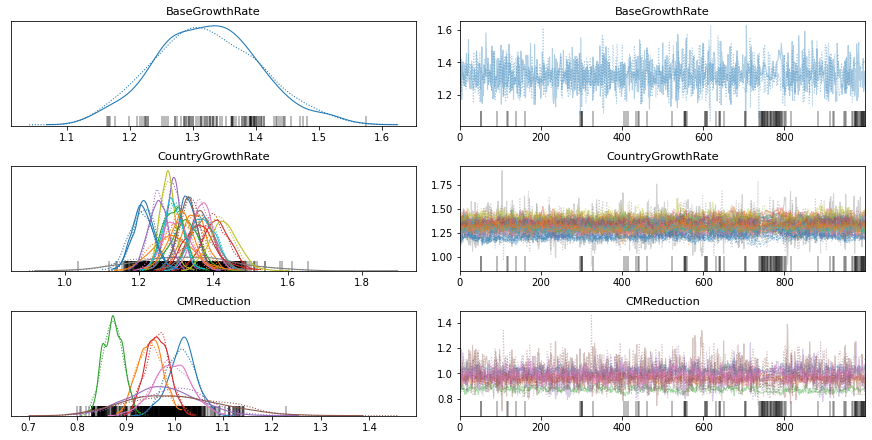

In [34]:
_ = pm.traceplot(trace, var_names=["BaseGrowthRate", "CountryGrowthRate", "CMReduction"])

## Plot inferred countermeasure effect

Effects are multiplicative (e.g. for a countermeasure that is a strenghtening of another, the inferred strenght is the additional multiplier).

The countermeasure strength is the multiplicative effect at feature=1.0.

 0 Gatherings limited to                    CMReduction 1.01 (0.965 .. 1.06)
 1 Business suspended                       CMReduction 0.951 (0.909 .. 0.995)
 2 Schools and universities closed          CMReduction 0.874 (0.842 .. 0.907)
 3 General curfew                           CMReduction 0.965 (0.926 .. 1.01)
 4 Healthcare specialisation                CMReduction 0.981 (0.866 .. 1.1)
 5 Phone line                               CMReduction 1 (0.856 .. 1.17)
 6 Asymptomatic contact isolation           CMReduction 0.996 (0.934 .. 1.06)


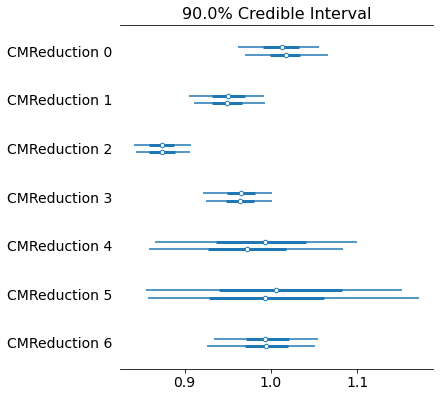

In [35]:
pm.forestplot(trace, var_names=['CMReduction'], credible_interval=0.9)
for i, c in enumerate(CMs):
    print(f"{i:2} {c:40} CMReduction {statstr(trace['CMReduction'][:,i])}")

In [36]:
import plotly
from plotly import graph_objects as go
import plotly.express as px
import datetime

def plot_line_CIs(fig, x, ys, name, color, quantiles=(0.05, 0.25), opacities=(0.1, 0.15)):
    x=list(x)
    fig.add_trace(go.Scatter(
        x=x,
        y=list(ys.mean(axis=0)),
        name=name, legendgroup=name, line_color=color
    ))    
    for q, o in zip(quantiles, opacities):
        ylo = list(np.quantile(ys, q, axis=0))
        yhi = list(np.quantile(ys, 1.0-q, axis=0))
        fig.add_trace(go.Scatter(
            x=x + x[::-1],
            y=ylo+yhi[::-1],
            fill='toself',
            fillcolor=color,
            opacity=o,
            line_color='rgba(255,255,255,0)',
            showlegend=False,
            name=name, legendgroup=name,
        ))    
        
fig = go.FigureWidget()
for i, c in enumerate(Cs):
    d = trace['DailyGrowth'][:,i,:]
    color = (px.colors.qualitative.Dark24 * 10)[i]
    plot_line_CIs(fig, Ds[CMDelayCut:], d, c, color)
datestr = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
plotly.io.write_html(fig, f'{datestr}_growth_estimated_v1.html', include_plotlyjs='cdn')
fig

FigureWidget({
    'data': [{'legendgroup': 'PL',
              'line': {'color': '#2E91E5'},
              'n…